In [1]:
# Standard packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Standard preprocessing and modeling imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Neural Network imports
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping

# Genius Import
import lyricsgenius as genius

# Disable warning messages
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Clean dataframe for modeling

In [2]:
# Read in master csv
master = pd.read_csv('./data/all_master_files')
# Drop Unnamed:0 column
master.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
master.shape

(4427, 15)

In [4]:
master.head()

,title,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,time_signature,duration_sec,hit
0,All Time Low,0.584,0.569,-4.259,1.0,0.1660,0.0508,0.000000,0.0924,0.501,89.779,0.0,4.0,217.603,1
1,Bleeding Love,0.638,0.656,-5.886,1.0,0.0357,0.1880,0.000000,0.1460,0.225,104.036,5.0,4.0,262.467,1
2,No One Compares To You,0.703,0.748,-6.047,1.0,0.0435,0.1230,0.000000,0.0642,0.625,111.943,1.0,4.0,184.080,1
3,Lollipop,0.828,0.433,-9.716,1.0,0.1990,0.0656,0.000876,0.1220,0.440,148.073,0.0,4.0,299.333,1
4,Apologize,0.591,0.718,-6.025,1.0,0.0368,0.3480,0.000118,0.1070,0.468,117.995,8.0,4.0,208.107,1


In [5]:
# Drop duplicates
master.drop_duplicates(inplace=True)
master.shape

(3129, 15)

# Building a neural network to predict hit songs

**Train Test Split**

In [6]:
# Set X features and y variable to predict
features = master.columns.drop(['title','hit'])
X = master[features]
y = master['hit']

In [7]:
# Instantiate train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
# Baseline score
y.value_counts(normalize=True)

0    0.905081
1    0.094919
Name: hit, dtype: float64

**Alleviate imbalanced classes**

In [9]:
# Our y variable is very imbalanced
pd.Series(y).value_counts()

0    2832
1     297
Name: hit, dtype: int64

In [10]:
# Instantiate and fit SMOTE to oversample the minority class
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [11]:
# Classes are now balanced
pd.Series(y_train_smote).value_counts()

1    2118
0    2118
dtype: int64

**Standard Scaler**

In [12]:
# Instantiate Standard Scaler
ss = StandardScaler()
# Fit and transform training features
X_train_sc = ss.fit_transform(X_train_smote)
# Transform test features
X_test_sc = ss.transform(X_test)

**Build Neural Network**

In [15]:
# Instantiate the Sequential Neural Net
model = Sequential()
# Create the input and first hidden layer
model.add(Dense(4236, 
                activation='relu', 
                input_dim=X_train_sc.shape[1]))
# Add hidden layer
model.add(Dense(1900, activation='relu'))
# Add hidden layer
model.add(Dense(200, activation='relu'))
# Add hidden layer
model.add(Dense(50, activation='relu'))
# Instantiate a Dropout regularizer
model.add(Dropout(0.5))
# Create output layer
model.add(Dense(1, activation='sigmoid'))

In [16]:
# Compile the model 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# Instantiate EarlyStopping
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2)

In [18]:
# Fit the neural net
results = model.fit(X_train_sc, y_train_smote, 
                    validation_data=(X_test_sc, y_test), 
                    epochs = 15,
                    callbacks=[early])

Train on 4236 samples, validate on 783 samples
Epoch 1/15
4236/4236 [==============================] - 29s 7ms/step - loss: 0.5663 - acc: 0.6976 - val_loss: 0.5605 - val_acc: 0.6922
Epoch 2/15
4236/4236 [==============================] - 27s 6ms/step - loss: 0.4739 - acc: 0.7812 - val_loss: 0.5052 - val_acc: 0.7318
Epoch 3/15
4236/4236 [==============================] - 27s 6ms/step - loss: 0.4152 - acc: 0.8059 - val_loss: 0.5023 - val_acc: 0.7395
Epoch 4/15
4236/4236 [==============================] - 33s 8ms/step - loss: 0.3600 - acc: 0.8371 - val_loss: 0.6201 - val_acc: 0.7241
Epoch 5/15
4236/4236 [==============================] - 34s 8ms/step - loss: 0.3394 - acc: 0.8555 - val_loss: 0.6855 - val_acc: 0.7267


In [19]:
# Generate model predictions 
preds = model.predict(X_test_sc)

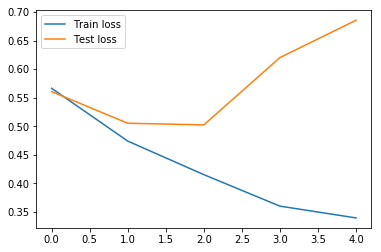

In [20]:
# Plot the results 
plt.plot(results.history['loss'], label='Train loss');
plt.plot(results.history['val_loss'], label='Test loss');
plt.legend();

# GridSearch a logistic regression model using audio features for interpretability 

In [21]:
# Build logistic regression parameters for Gridsearch
params = {
    'penalty': ['l1', 'l2'],
    'C': [1, 5, 10]
}

In [22]:
# Instantiate Gridsearch for logistic regression
gs = GridSearchCV(estimator=LogisticRegression(),
                 param_grid=params)

In [27]:
# Fit the GridSearch model
gs.fit(X_train_sc, y_train_smote)
# Print the best accuracy score
print('The best score is: ', gs.best_score_)
# Print the best parameters to use
print('The best parameters to use are: ', gs.best_params_)
# Generate model predictions
gs_preds = gs.predict(X_test_sc)
# Print the recall score
print('The recall score is: ', recall_score(y_test, gs_preds)

0.6231884057971014

In [28]:
# Create a logistic regression model with the best parameters
lr = LogisticRegression(C=5)
lr.fit(X_train_sc, y_train_smote)
lr.score(X_test_sc, y_test)

0.6283524904214559

In [29]:
# Create a dataframe with feature coefficients to see which features have most influence on a hit song
pd.DataFrame(lr.coef_, columns=features, index=['coefficients']).T.sort_values('coefficients')

,coefficients
energy,-0.627122
instrumentalness,-0.342719
acousticness,-0.154411
valence,-0.071294
tempo,-0.065701
duration_sec,-0.033974
liveness,-0.021042
time_signature,0.052033
mode,0.083846
speechiness,0.101722


In [30]:
y_test.value_counts()

0    714
1     69
Name: hit, dtype: int64

In [31]:
# Generate a confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, gs_preds), 
                  columns=['predicted not hit', 'predicted hit'],
                  index=['actual not hit', 'actual hit'])
# Print the recall score
print(recall_score(y_test, gs_preds))
cm

0.6231884057971014


,predicted not hit,predicted hit
actual not hit,449,265
actual hit,26,43


In [32]:
# Horizontal bar chart

# Building a logistic regression model to analyze song lyrics

In [33]:
# Read in data
master_08 = pd.read_csv('./data/MASTER_2008_lyrics')
master_13 = pd.read_csv('./data/MASTER_2013_lyrics')
master_18 = pd.read_csv('./data/MASTER_2018_lyrics')

In [34]:
# Drop 'Unnamed: 0' column
master_18.drop('Unnamed: 0', axis=1, inplace=True)
master_13.drop('Unnamed: 0', axis=1, inplace=True)
master_08.drop('Unnamed: 0', axis=1, inplace=True)

In [35]:
# Check for imbalanced classes 
print(master_18['hit'].value_counts())
print('')
print(master_13['hit'].value_counts())
print('')
print(master_08['hit'].value_counts())

0    1373
1      98
Name: hit, dtype: int64

0    2696
1      95
Name: hit, dtype: int64

0    1935
1      98
Name: hit, dtype: int64


In [36]:
'''
Create a function that preprocesses the dataset for modeling, remedies imbalanced classes, models the data
and returns a confusion matrix with the printed recall score
'''
def lyrics_model(df):
    # Set X and y and train test split
    X = df['tokenized_lyrics']
    y= df['hit']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Instantiate CountVectorizer
    cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,5))
    # Fit and transform features from training data
    X_train_cv = cv.fit_transform(X_train)
    # Transform features from testing data
    X_test_cv = cv.transform(X_test)
    
    # Instantiate SMOTE to remedy imbalanced classes and resample minority class
    sm = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_smote, y_train_smote = sm.fit_resample(X_train_cv, y_train)
    
    # Instantiate logistic regression
    lr = LogisticRegression()
    # Fit the model
    lr.fit(X_train_smote, y_train_smote)
    # Print the model's accuracy score 
    print('The accuracy score is: ', lr.score(X_test_cv, y_test))
    # Create predictions
    preds = lr.predict(X_test_cv)
    # Print the recall score
    print('The recall score is: ', recall_score(y_test, preds))
    
    # Create a confusion matrix
    cm = pd.DataFrame(confusion_matrix(y_test, preds), 
                      columns=['predicted not hit', 'predicted hit'],
                      index=['actual not hit', 'actual hit'])
    return cm   # Return confusion matrix

In [37]:
master_08.head()

,lyrics,hit,tokenized_lyrics,stemmed_lyrics
0,Hmm mmm mmm mmm mmm mmm Let me talk to em let ...,1,hmm mmm mmm mmm mmm mmm let me talk to em let ...,hmm mmm mmm mmm mmm mmm let me talk to em let ...
1,Closed off from love I didnt need the pain Onc...,1,closed off from love i didnt need the pain onc...,close off from love i didnt need the pain onc ...
2,I just want you close Where you can stay forev...,1,i just want you close where you can stay forev...,i just want you close where you can stay forev...
3,Oww! Uh huh No homo Young Mula baby I said hes...,1,oww uh huh no homo young mula baby i said hes ...,oww uh huh no homo young mula babi i said he s...
4,Im holding on your rope got me ten feet off th...,1,im holding on your rope got me ten feet off th...,im hold on your rope got me ten feet off the g...


In [38]:
lyrics_model(master_08)

0.0


,predicted not hit,predicted hit
actual not hit,469,19
actual hit,21,0


In [39]:
lyrics_model(master_13)

0.047619047619047616


,predicted not hit,predicted hit
actual not hit,665,12
actual hit,20,1


In [40]:
lyrics_model(master_18)

0.34782608695652173


,predicted not hit,predicted hit
actual not hit,341,4
actual hit,15,8


# Merging audio features and lyrics together to see if model perfomance enhances
**The merge between master audio features and master lyrics dataframes will occur on the `title` column. In order to merge on this column, we need to retrieve titles for the lyrics dataframe through Genius' API.**

In [41]:
# Create Genius object
genius = genius.Genius(client_access_token='1ZxV3C-PK6E8hlkD3GCk_a8H61dNIE9YFEWgmfAEfQF2BVvsIJTryB8uZw4SslZ4', 
              response_format='plain',         # Format of response is plain text
              timeout=5, sleep_time=0.5, 
              remove_section_headers=True,     # Remove headers such as [Intro], [Verse], [Chorus]n etc.
              skip_non_songs=True,             # Skip items that are not songs
              verbose=False)                   # Dont print search text

In [42]:
# Function that will retrieve song titles by searching by song lyrics and create a 'title' dataframe column
def get_titles(df):
    title = []                                       # Empty list
    for lyrics in df['lyrics']:                      # For loop to iterate through song lyrics in lyrics column
        try:                                         # Try and except statement in case errors occur
            lyrics = genius.search_song(lyrics)      # Genius API query that searches by song lyrics
            title.append(lyrics.title)               # Append the song title to empty list 
            time.sleep(2)                            # Wait 2 seconds before continuing the loop
        except:
            title.append('Error')                    # Append "Error" to empty list if an error occurs
    return title
#     df['title'] = title                              # Create 'title' column in the dataframe

In [43]:
master_lyrics = pd.concat([master_08, master_13, master_18])
master_lyrics.reset_index(inplace=True)

In [44]:
master_lyrics.shape

(6295, 5)

In [ ]:
get_titles(master_lyrics)

In [97]:
def clean_title(df, col):
    cleaned_title = []
    for title in df[col]:
        try:
            a = title.index('feat.')
            cleaned_title.append(title[:a-1].replace('-', ''))
        except:
            cleaned_title.append(title)
    return cleaned_title

In [104]:
apple = clean_title(master, col='title')

In [114]:
master.shape

(3129, 15)

In [113]:
test = pd.DataFrame(apple, columns=['title']) 
test[test['title'] == 'Error']

,title
99,Error
100,Error
101,Error
102,Error
103,Error
104,Error
105,Error
106,Error
107,Error
108,Error


In [ ]:
master.merge(master_lyrics, on='title')